# Comparison of ECG Processing Results

This notebook compares the old processed data (`data_300s_order5.csv`) with the new processed data (`data_300s_order5_rmNegativeRRI.csv`) which implemented PCHIP interpolation and clipping to fix negative RRI values.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths
OLD_FILE = r'd:\OneDrive\Desktop\The big project\ecg-ordinal-aging\data\processed\seg_300s\data_300s_order5.csv'
NEW_FILE = r'd:\OneDrive\Desktop\The big project\ecg-ordinal-aging\data\processed\seg_300s\data_300s_order5_rmNegativeRRI.csv'

print("Loading datasets...")
# Force ID to string to maintain leading zeros (e.g. '0244')
df_old = pd.read_csv(OLD_FILE, dtype={'ID': str})
df_new = pd.read_csv(NEW_FILE, dtype={'ID': str})

print(f"Old Shape: {df_old.shape}")
print(f"New Shape: {df_new.shape}")

Loading datasets...
Old Shape: (3356, 1224)
New Shape: (3356, 1224)


## 1. Compare Sample Counts and IDs

In [7]:
ids_old = set(df_old['ID'])
ids_new = set(df_new['ID'])

common = ids_old.intersection(ids_new)
removed = ids_old - ids_new
added = ids_new - ids_old

print(f"Common IDs: {len(common)}")
print(f"IDs Removed in New File: {len(removed)}")
print(f"IDs Added in New File (unexpected): {len(added)}")

if removed:
    print(f"\nSample removed IDs: {list(removed)[:10]}")
else:
    print("\nNo IDs were removed.")

# Check for duplicated IDs (segments)
print(f"\nOld Total Rows: {len(df_old)}")
print(f"New Total Rows: {len(df_new)}")
diff_rows = len(df_old) - len(df_new)
print(f"Row difference: {diff_rows}")

Common IDs: 1092
IDs Removed in New File: 0
IDs Added in New File (unexpected): 0

No IDs were removed.

Old Total Rows: 3356
New Total Rows: 3356
Row difference: 0


## 2. Check Global Statistics (Negative RRI check)

In [8]:
rri_cols_old = [c for c in df_old.columns if c.startswith('RRI_')]
rri_cols_new = [c for c in df_new.columns if c.startswith('RRI_')]

# Convert to numeric, forcing errors to NaN just in case
df_old_rri = df_old[rri_cols_old].apply(pd.to_numeric, errors='coerce')
df_new_rri = df_new[rri_cols_new].apply(pd.to_numeric, errors='coerce')

min_old = df_old_rri.min().min()
max_old = df_old_rri.max().max()

min_new = df_new_rri.min().min()
max_new = df_new_rri.max().max()

print(f"OLD RRI Range: [{min_old:.4f}, {max_old:.4f}]")
print(f"NEW RRI Range: [{min_new:.4f}, {max_new:.4f}]")

neg_count_old = (df_old_rri <= 0).sum().sum()
neg_count_new = (df_new_rri <= 0).sum().sum()

print(f"\nTotal values <= 0 in OLD: {neg_count_old}")
print(f"Total values <= 0 in NEW: {neg_count_new}")

OLD RRI Range: [-44.2056, 75.3910]
NEW RRI Range: [0.3010, 2.0000]

Total values <= 0 in OLD: 611
Total values <= 0 in NEW: 0


## 3. Visualize Correction for ID 0244
Looking at the specific ID that had the massive negative dip.

ID 0244 found!


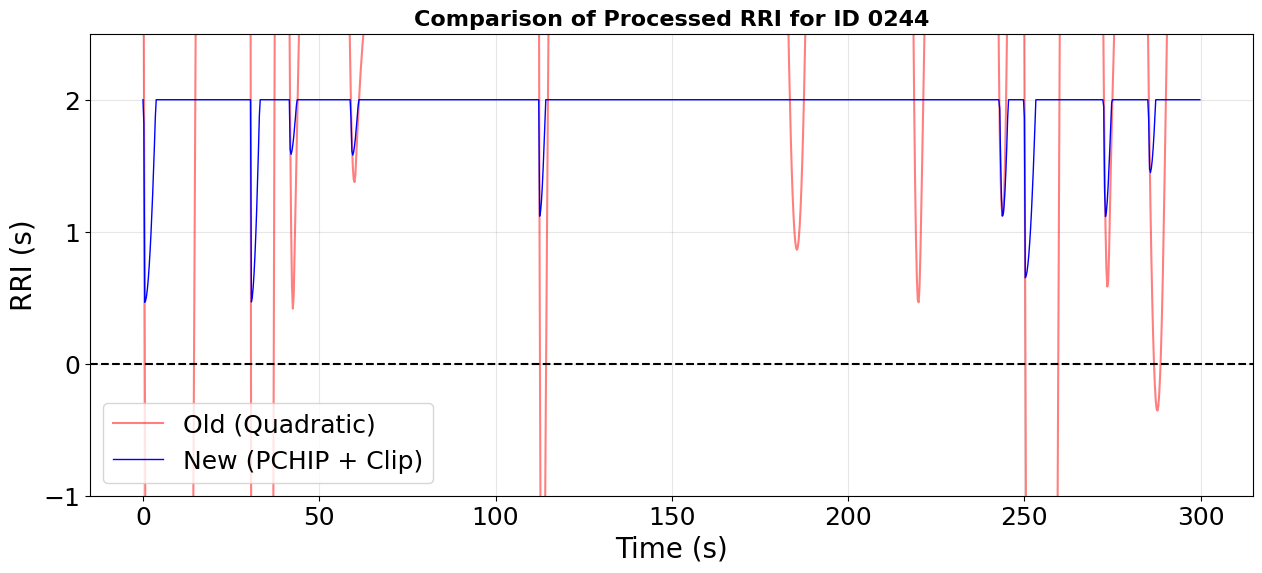

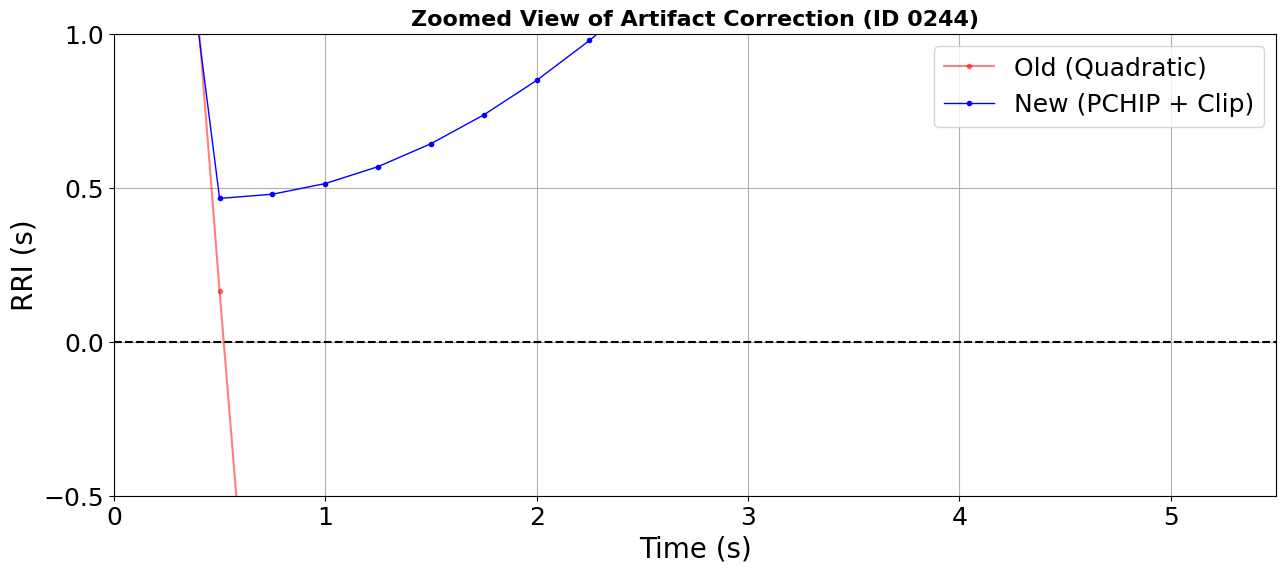

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# --- CẤU HÌNH FONT SIZE ---
SIZE_TITLE = 16
SIZE_LABEL = 20
SIZE_TICKS = 18
SIZE_LEGEND = 18

TARGET_ID = "0244"

row_old = df_old[df_old['ID'] == TARGET_ID]
row_new = df_new[df_new['ID'] == TARGET_ID]

if not row_old.empty and not row_new.empty:
    print(f"ID {TARGET_ID} found!")
    
    y_old = row_old.iloc[0][rri_cols_old].values.astype(float)
    y_new = row_new.iloc[0][rri_cols_new].values.astype(float)
    x_axis = np.arange(len(y_old)) * 0.25
    
    # --- BIỂU ĐỒ 1: TỔNG QUAN ---
    plt.figure(figsize=(15, 6))
    plt.plot(x_axis, y_old, label='Old (Quadratic)', color='red', alpha=0.5)
    plt.plot(x_axis, y_new, label='New (PCHIP + Clip)', color='blue', linewidth=1)
    
    plt.axhline(0, color='black', linestyle='--')
    plt.ylim(-1, 2.5) 

    # Áp dụng các biến fontsize
    plt.title(f"Comparison of Processed RRI for ID {TARGET_ID}", fontsize=SIZE_TITLE, fontweight='bold')
    plt.ylabel("RRI (s)", fontsize=SIZE_LABEL)
    plt.xlabel("Time (s)", fontsize=SIZE_LABEL)
    plt.legend(fontsize=SIZE_LEGEND)
    plt.xticks(fontsize=SIZE_TICKS)
    plt.yticks(fontsize=SIZE_TICKS)
    
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # --- BIỂU ĐỒ 2: ZOOMED VIEW ---
    plt.figure(figsize=(15, 6))
    plt.plot(x_axis, y_old, label='Old (Quadratic)', color='red', alpha=0.5, marker='.')
    plt.plot(x_axis, y_new, label='New (PCHIP + Clip)', color='blue', linewidth=1, marker='.')
    plt.axhline(0, color='black', linestyle='--')
    
    neg_indices = np.where(y_old < 0.2)[0]
    if len(neg_indices) > 0:
        center = neg_indices[0]
        start_zoom = max(0, (center*0.25)-5)
        end_zoom = min(x_axis[-1], (center*0.25)+5)
        plt.xlim(start_zoom, end_zoom)
        plt.ylim(-0.5, 1.0)
        plt.title(f"Zoomed View of Artifact Correction (ID {TARGET_ID})", fontsize=SIZE_TITLE, fontweight='bold')
    else:
        plt.title(f"Zoomed View (Start) for ID {TARGET_ID}", fontsize=SIZE_TITLE, fontweight='bold')
        plt.xlim(0, 20)
        plt.ylim(0, 1.5)
        
    # Áp dụng các biến fontsize
    plt.ylabel("RRI (s)", fontsize=SIZE_LABEL)
    plt.xlabel("Time (s)", fontsize=SIZE_LABEL)
    plt.legend(fontsize=SIZE_LEGEND)
    plt.xticks(fontsize=SIZE_TICKS)
    plt.yticks(fontsize=SIZE_TICKS)
    
    plt.grid(True)
    plt.show()